In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Load data

In [2]:
# Load data from the CSV file into a new DataFrame
data = pd.read_csv('./model/gps_data.csv')
data

,Person ID,Latitude,Longitude,0,Altitude,NumDays,Date,Time
0,0,39.984702,116.318417,0,492.000000,39744.120185,2008-10-23,02:53:04
1,0,39.984683,116.318450,0,492.000000,39744.120255,2008-10-23,02:53:10
2,0,39.984686,116.318417,0,492.000000,39744.120313,2008-10-23,02:53:15
3,0,39.984688,116.318385,0,492.000000,39744.120370,2008-10-23,02:53:20
4,0,39.984655,116.318263,0,492.000000,39744.120428,2008-10-23,02:53:25
...,...,...,...,...,...,...,...,...
19994530,18668,39.988783,116.299000,0,114.829396,39495.446632,2008-02-17,10:43:09
19994531,18668,39.989500,116.298667,0,98.425197,39495.447176,2008-02-17,10:43:56
19994532,18668,39.990067,116.298350,0,131.233596,39495.447523,2008-02-17,10:44:26
19994533,18668,39.989517,116.298417,0,150.918635,39495.448183,2008-02-17,10:45:23


Load transportation data

In [3]:
# Load data from the CSV file into a new DataFrame
data_labels = pd.read_csv('./model/labels_data.csv')
data_labels

,Start Time,End Time,Transportation Mode
0,2007/06/26 11:32:29,2007/06/26 11:40:29,bus
1,2008/03/28 14:52:54,2008/03/28 15:59:59,train
2,2008/03/28 16:00:00,2008/03/28 22:02:00,train
3,2008/03/29 01:27:50,2008/03/29 15:59:59,train
4,2008/03/29 16:00:00,2008/03/30 15:59:59,train
...,...,...,...
14713,2008/11/17 06:59:58,2008/11/17 07:06:16,bus
14714,2008/11/17 07:06:16,2008/11/17 07:14:32,walk
14715,2008/11/29 01:58:05,2008/11/29 02:01:39,bus
14716,2008/11/29 02:01:39,2008/11/29 02:07:57,walk


Distribution of transportation nodes

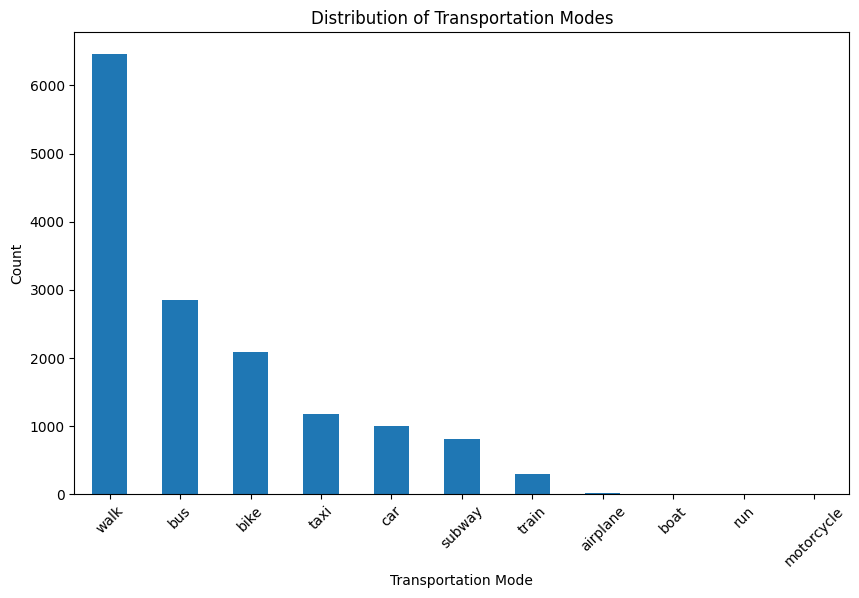

In [4]:
x = data_labels['Transportation Mode'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
x.plot(kind='bar')
plt.xlabel('Transportation Mode')
plt.ylabel('Count')
plt.title('Distribution of Transportation Modes')
plt.xticks(rotation=45)
plt.show()


Heatmap GPS density

In [7]:
import plotly.express as px

n_samples = 50000
gps_data = pd.read_csv('./model/gps_data.csv').sample(n=n_samples)

# Create a heatmap with Plotly
fig = px.density_mapbox(
    gps_data, 
    lat='Latitude', 
    lon='Longitude', 
    radius=10,
    center=dict(lat=gps_data['Latitude'].mean(), lon=gps_data['Longitude'].mean()),  # Center the map on the data
    zoom=10,  # Adjust the zoom level as needed
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()
